In [1]:
## Preliminary

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV

!pip install mitosheet 
import mitosheet 

!pip install xgboost
import xgboost

%config InlineBackend.figure_format = "svg"

In [3]:
data = pd.read_csv('../datasets/train.csv')

In [117]:
data["host_id"].nunique()

4919

In [4]:
df = data.sample(n=500, random_state=42)

In [5]:
df.head()

,property_id,property_name,property_summary,property_space,property_desc,property_neighborhood,property_notes,property_transit,property_access,property_interaction,...,reviews_rating,reviews_acc,reviews_cleanliness,reviews_checkin,reviews_communication,reviews_location,reviews_value,reviews_per_month,extra,target
3100,3105,BrusselS&HomeLongTermTopKeyLocation,Brussels - Long term - European Institutions T...,42m2. Studio/loft Double bed + sofa,Brussels - Long term - European Institutions T...,The crown jewel of Brussels’ Old Town is the G...,NaN,"""Trône"" station 5' away",Dishwasher + WashingMachineDryer InternetTv (N...,NaN,...,91.0,10.0,9.0,9.0,9.0,9.0,9.0,5.06,Host Has Profile Pic,35
2251,2256,Flat au centre ville,Idéalement situé pour les amateurs de shopping...,"Agréable flat bien équipé, avec parquet , port...",Idéalement situé pour les amateurs de shopping...,NaN,min 3 nuitées,"Tout passe par ici !!! Métro, gare , bus, tram...","Wifi ok, le logement est entier, donc ok pour ...",Le flat est situé au pied du parc Maximilien d...,...,91.0,10.0,9.0,10.0,9.0,9.0,9.0,4.42,"Host Has Profile Pic, Instant Bookable",65
1695,1700,Charming studio next Avenue louise,"My studio is located next Place Stéphanie, in ...","The accommodation is quite cozy, bright, and c...","My studio is located next Place Stéphanie, in ...",The avenue Louise is an avenue of Brussels ext...,NaN,"There is a tram stop at two minutes, as well a...",Travellers have access to the entire accommoda...,"I can offer my help for any questions, I am re...",...,93.0,10.0,10.0,10.0,10.0,9.0,9.0,0.90,"Host Has Profile Pic, Is Location Exact",100
2775,2780,Quiet Oasis in the Bustling Nationalestraat,Our studio is located in the bustling National...,The completely renovated studio with a surface...,Our studio is located in the bustling National...,"The Nationalestraat is a bustling street, that...",NaN,"Guests who travel by car, can leave their vehi...",The studio is located at the second floor of a...,We welcome our guests personally at their arri...,...,96.0,10.0,10.0,10.0,10.0,10.0,10.0,5.14,"Host Has Profile Pic, Is Location Exact",45
1436,1440,105 m2 appartment next to Flagey/Louise,The appartment is very close to the Café Belga...,- quite - lots of light - totally refurbished ...,The appartment is very close to the Café Belga...,"We are a few steps from the European Quarter, ...",You have a nice restaurant and animated bars f...,"We are 2 min away (walking) from TRAM : 81, 83...",Full appartment,You will have the full apartment (on your own)...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Host Has Profile Pic, Is Location Exact, Insta...",64


In [6]:
## EDA: property_zipcode

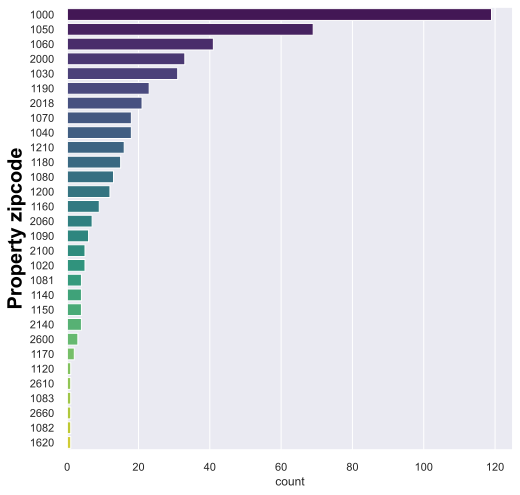

In [7]:
sns.set(style='darkgrid')
plt.figure(figsize=(8,8))
sns.countplot(y = 'property_zipcode',data = df,order = df['property_zipcode'].value_counts().index,palette = "viridis")
plt.ylabel('Property zipcode',fontsize = 20, weight = 'bold',color='black')
#plt.axes().set(facecolor = "White")
plt.show()

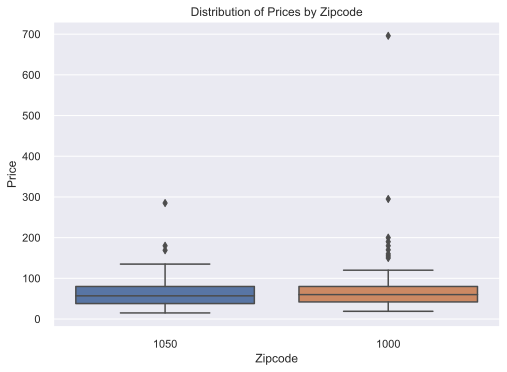

In [8]:
# set the threshold number of observations
threshold = 50

# group the data by property_zipcode and count the number of observations for each group
counts = df.groupby('property_zipcode').size()

# filter out the zipcodes with less than the threshold number of observations
valid_zipcodes = counts[counts >= threshold].index

# subset the data to only include the valid zipcodes
valid_data = df[df['property_zipcode'].isin(valid_zipcodes)]

# create a box plot of the prices for each valid property_zipcode
sns.boxplot(x='property_zipcode', y='target', data=valid_data)
sns.set(rc={'figure.figsize':(15,10)}) # set the figure size
plt.title('Distribution of Prices by Zipcode')
plt.xlabel('Zipcode')
plt.ylabel('Price')
plt.show()

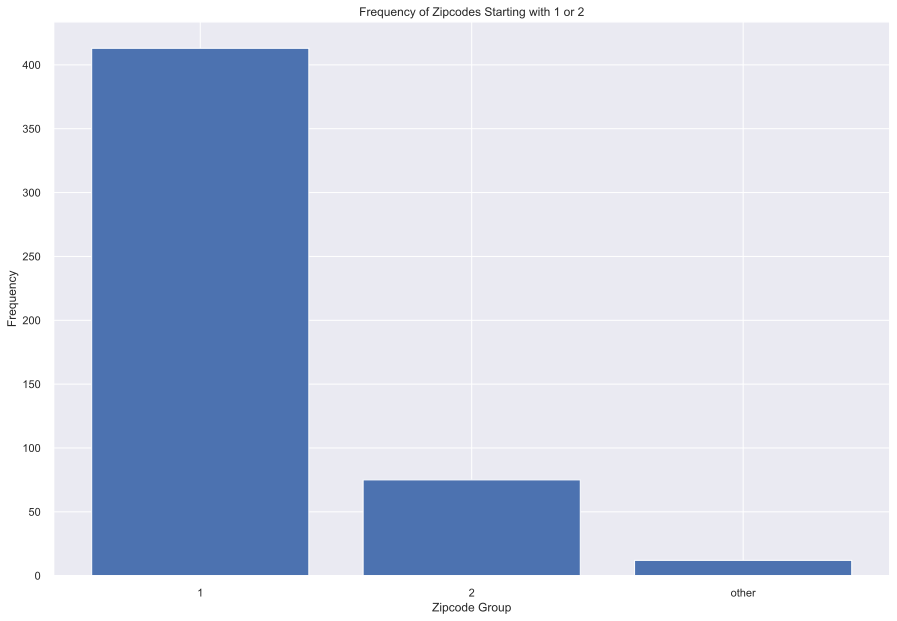

In [9]:
# create a new column that indicates whether the property_zipcode starts with '1' or '2'
df['zipcode_group'] = df['property_zipcode'].apply(lambda x: '1' if str(x).startswith('1') else '2' if str(x).startswith('2') else 'other')

# group the data by zipcode_group and count the number of observations for each group
zipcode_counts = df.groupby('zipcode_group').size()

# create a histogram of the frequency of zipcodes that start with '1' or '2'
plt.bar(zipcode_counts.index, zipcode_counts.values)
plt.title('Frequency of Zipcodes Starting with 1 or 2')
plt.xlabel('Zipcode Group')
plt.ylabel('Frequency')
plt.show()

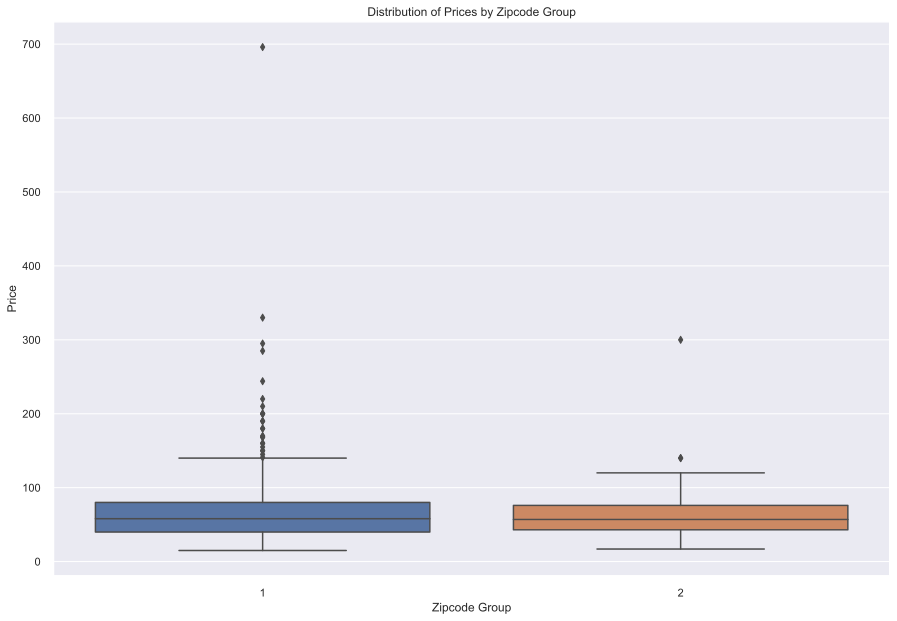

In [10]:
# first remove all the nan values
df = df.dropna(subset=['property_zipcode'])

# create a new DataFrame that only includes the zipcodes starting with '1' or '2'
valid_data = df[df['property_zipcode'].str.startswith(('1', '2'))]

# create a box plot of the prices for each zipcode group
sns.boxplot(x=valid_data['property_zipcode'].apply(lambda x: x[0]), y='target', data=valid_data)
sns.set(rc={'figure.figsize':(15,10)}) # set the figure size
plt.title('Distribution of Prices by Zipcode Group')
plt.xlabel('Zipcode Group')
plt.ylabel('Price')
plt.show()

In [11]:
zipcode_groups = valid_data.groupby(valid_data['property_zipcode'].str[0])
stats_by_zipcode_group = zipcode_groups['target'].describe()

# display the statistics for each group
print(stats_by_zipcode_group)

                  count       mean        std   min   25%   50%   75%    max
property_zipcode                                                            
1                 413.0  67.845036  52.575052  15.0  40.0  58.0  80.0  696.0
2                  75.0  64.613333  38.175234  17.0  43.0  57.0  76.0  300.0


In [12]:
## EDA: longitude and latitude

In [13]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [15]:
import folium
import pandas as pd
import random

# assume that you have a pandas DataFrame named 'df' that contains the columns 'property_lon', 'property_lat', 'price', and 'property_zipcode'

# define the color scheme
def get_color(target):
    if target <= 40:
        return 'green'
    elif target <= 55:
        return 'orange'
    else:
        return 'red'

# create a map of Brussels centered at the coordinates of Brussels
brussels_coordinates = [50.8503, 4.3517]
brussels_map = folium.Map(location=brussels_coordinates, zoom_start=12)

# add a marker for each property in a random sample of 200 properties in Brussels with a color based on the price
brussels_data = df[df['property_zipcode'].str.startswith('1')].dropna(subset=['property_lon', 'property_lat'])
for _, row in brussels_data.iterrows():
    folium.Marker(location=[row['property_lat'], row['property_lon']], icon=folium.Icon(color=get_color(row['target']))).add_to(brussels_map)

# create a map of Antwerp centered at the coordinates of Antwerp
antwerp_coordinates = [51.2194, 4.4025]
antwerp_map = folium.Map(location=antwerp_coordinates, zoom_start=12)

# add a marker for each property in a random sample of 200 properties in Antwerp with a color based on the price
antwerp_data = df[df['property_zipcode'].str.startswith('2')].dropna(subset=['property_lon', 'property_lat'])
for _, row in antwerp_data.iterrows():
    folium.Marker(location=[row['property_lat'], row['property_lon']], icon=folium.Icon(color=get_color(row['target']))).add_to(antwerp_map)

# display the maps
brussels_map


In [16]:
antwerp_map


In [17]:
corr_table = df[['target', 'property_lat', 'property_lon']].corr()
print(corr_table)

                target  property_lat  property_lon
target        1.000000     -0.021924      0.004371
property_lat -0.021924      1.000000      0.572342
property_lon  0.004371      0.572342      1.000000


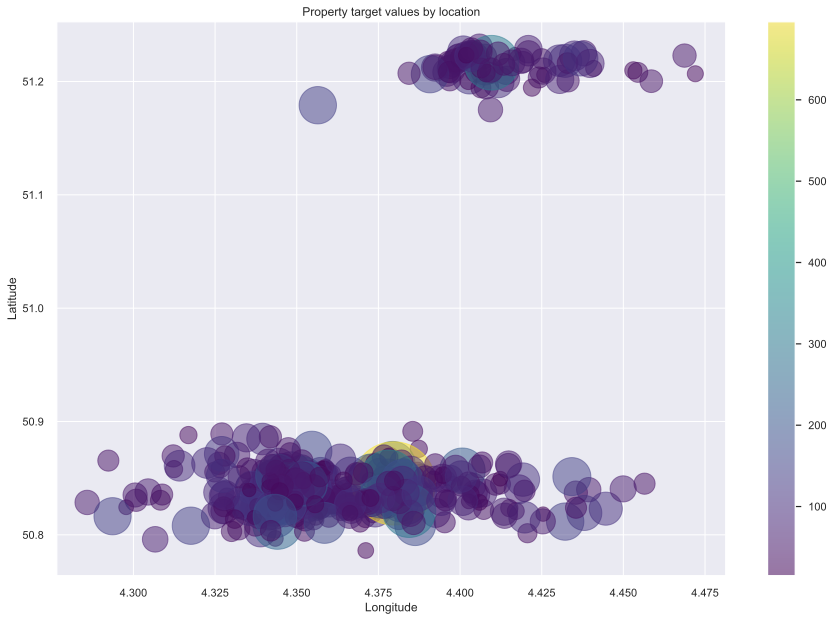

In [18]:
# create a scatter plot of longitude and latitude, with target determining the color and size of the markers
plt.scatter(df['property_lon'], df['property_lat'], c=df['target'], cmap='viridis', s=df['target']*10, alpha=0.5)

# add a colorbar to the plot
plt.colorbar()

# set the axis labels and plot title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Property target values by location')

# show the plot
plt.show()

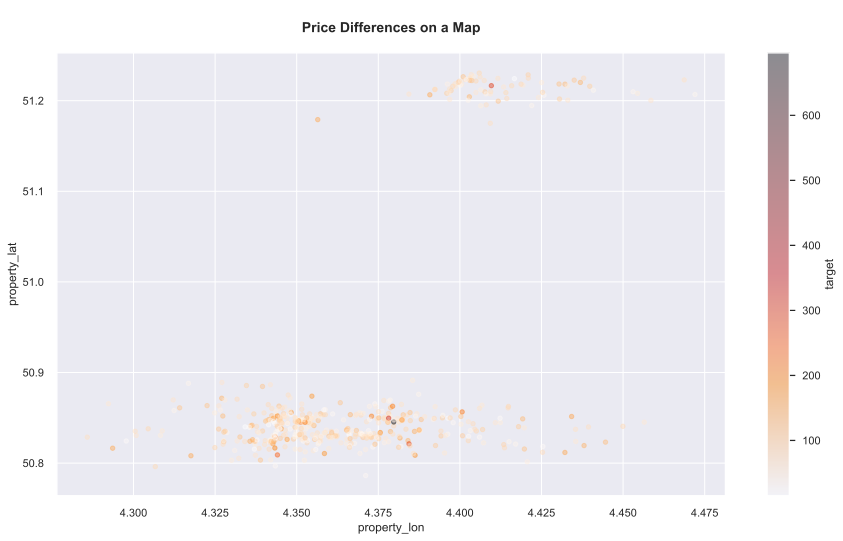

In [19]:
df.plot(kind="scatter", x="property_lon", y="property_lat", alpha=0.4,
        c="target", cmap="gist_heat_r", colorbar=True, sharex=False, figsize=(15,8));
plt.title('\nPrice Differences on a Map\n', fontsize=14, fontweight='bold');

In [20]:
!pip install geopy
import geopy

/var/folders/br/y1wjgh1n2xxdt0ghw8bn5r_00000gn/T/ipykernel_45037/521367070.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zip1['distance_to_brussels'] = df_zip1.apply(calc_distance, axis=1)


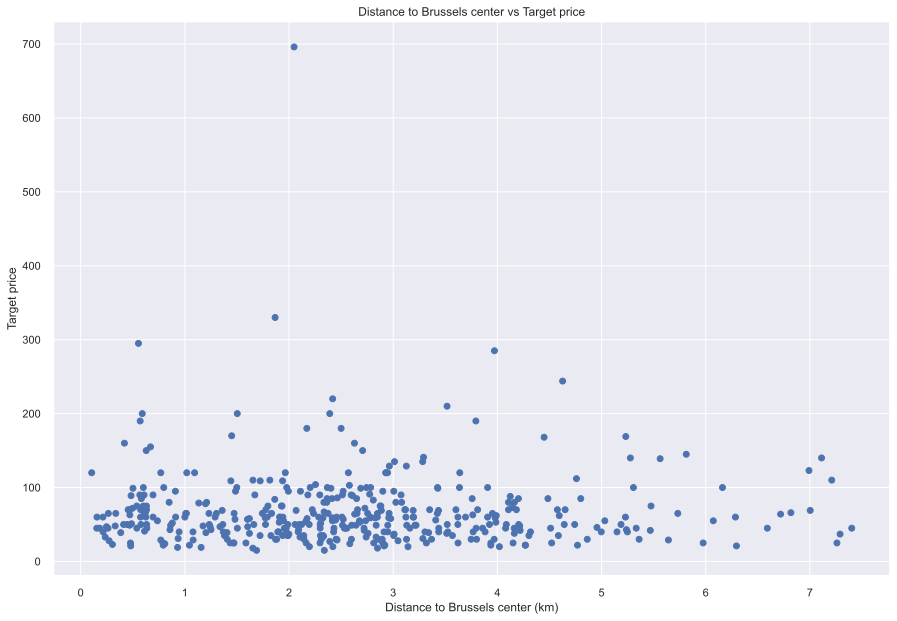

In [21]:
# filter for zip codes starting with '1'
df_zip1 = df[df['property_zipcode'].str.startswith('1')]

# calculate distance to center of Brussels (50.8503° N, 4.3517° E)
from geopy.distance import distance
brussels_center = (50.8503, 4.3517)

def calc_distance(row):
    lat = row['property_lat']
    lon = row['property_lon']
    return distance(brussels_center, (lat, lon)).km

df_zip1['distance_to_brussels'] = df_zip1.apply(calc_distance, axis=1)

# scatter plot of distance vs target price
plt.scatter(df_zip1['distance_to_brussels'], df_zip1['target'])
plt.xlabel('Distance to Brussels center (km)')
plt.ylabel('Target price')
plt.title('Distance to Brussels center vs Target price')
plt.show()


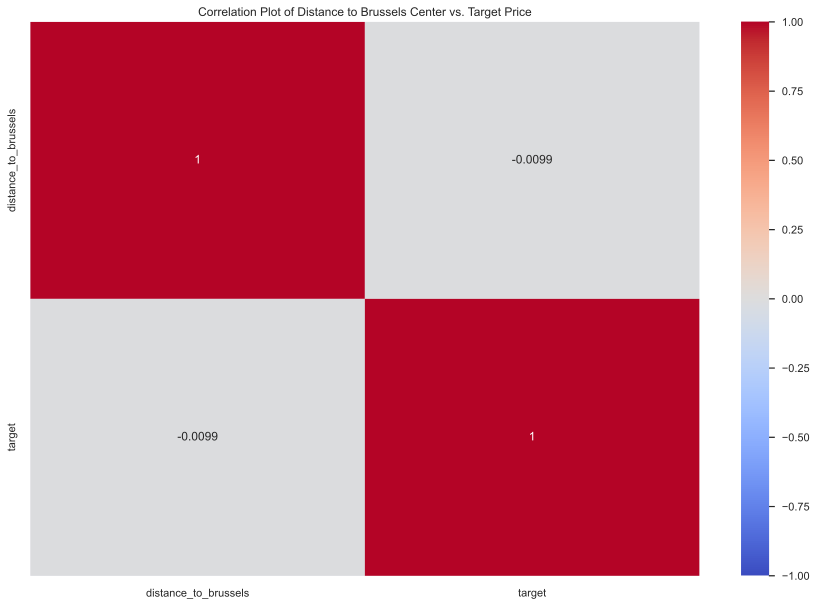

In [22]:
corr_matrix = df_zip1[['distance_to_brussels', 'target']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Plot of Distance to Brussels Center vs. Target Price')
plt.show()

/var/folders/br/y1wjgh1n2xxdt0ghw8bn5r_00000gn/T/ipykernel_45037/4058869645.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zip1['distance_to_antwerp'] = df_zip1.apply(calc_distance, axis=1)


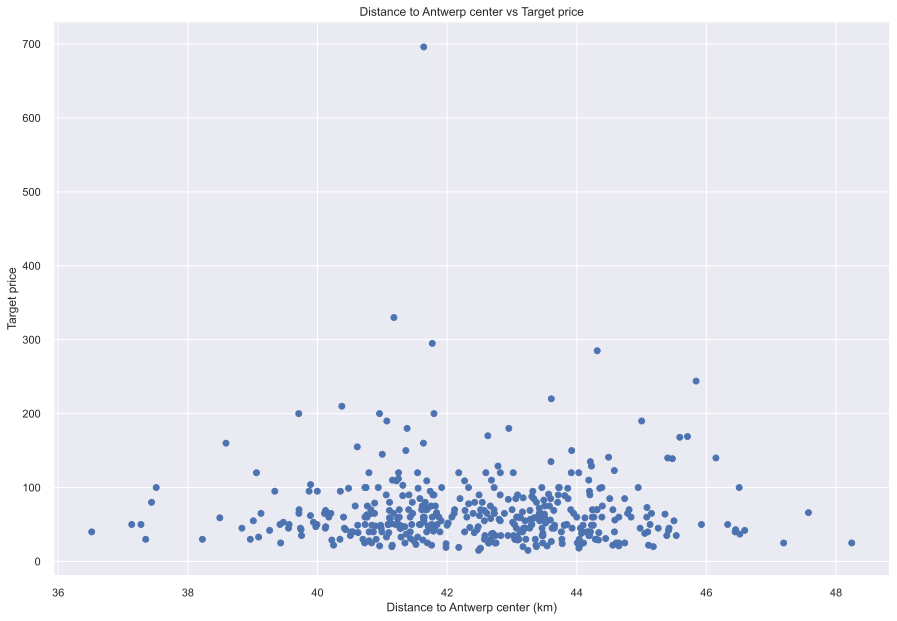

In [23]:
# filter for zip codes starting with '1'
df_zip2 = df[df['property_zipcode'].str.startswith('2')]

# calculate distance to center of Brussels (50.8503° N, 4.3517° E)
from geopy.distance import distance
brussels_center = (51.2194, 4.4025)

def calc_distance(row):
    lat = row['property_lat']
    lon = row['property_lon']
    return distance(brussels_center, (lat, lon)).km

df_zip1['distance_to_antwerp'] = df_zip1.apply(calc_distance, axis=1)

# scatter plot of distance vs target price
plt.scatter(df_zip1['distance_to_antwerp'], df_zip1['target'])
plt.xlabel('Distance to Antwerp center (km)')
plt.ylabel('Target price')
plt.title('Distance to Antwerp center vs Target price')
plt.show()

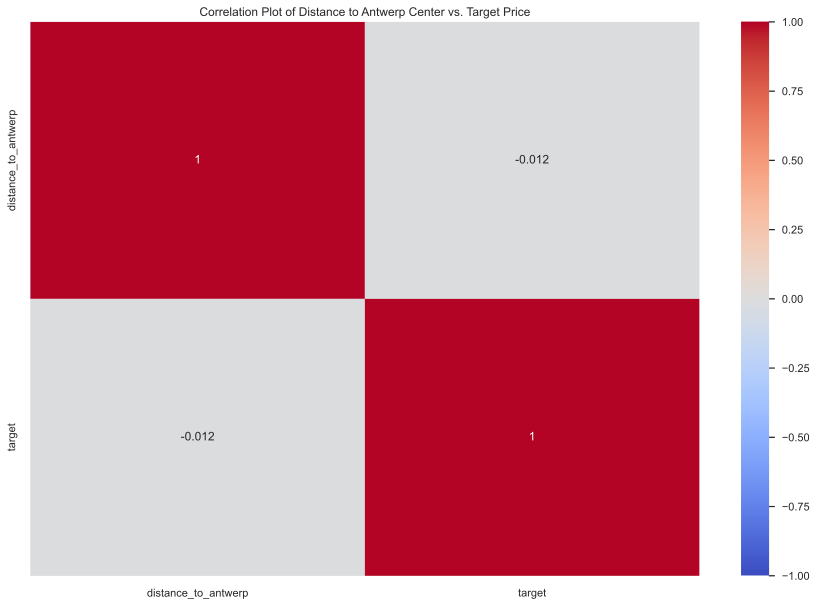

In [24]:
corr_matrix = df_zip1[['distance_to_antwerp', 'target']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Plot of Distance to Antwerp Center vs. Target Price')
plt.show()

In [25]:
## EDA: property_type

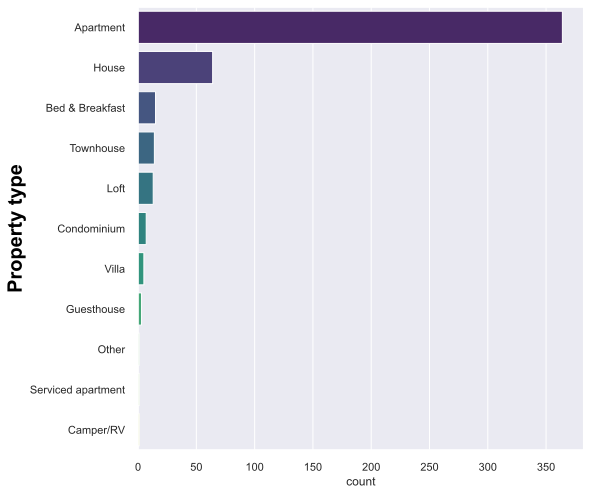

In [26]:
sns.set(style='darkgrid')
plt.figure(figsize=(8,8))
sns.countplot(y = 'property_type',data = df,order = df['property_type'].value_counts().index,palette = "viridis")
plt.ylabel('Property type',fontsize = 20, weight = 'bold',color='black')
#plt.axes().set(facecolor = "White")
plt.show()

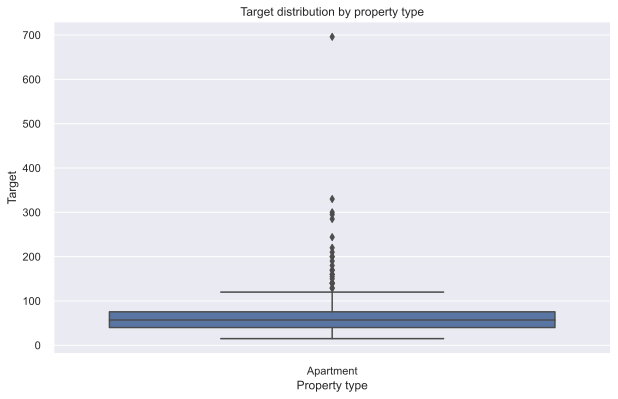

In [29]:
# filter the dataframe to only include rows with property_room_type that appear more than 300 times
room_type_counts = df['property_type'].value_counts()
popular_room_types = room_type_counts[room_type_counts > 100].index.tolist()
filtered_df = df[df['property_type'].isin(popular_room_types)]

# generate the boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='property_type', y='target', data=filtered_df)
ax.set_title('Target distribution by property type')
ax.set_xlabel('Property type')
ax.set_ylabel('Target')
plt.show()



In [30]:
# generate the statistical description
filtered_df.groupby('property_type')['target'].describe()

,count,mean,std,min,25%,50%,75%,max
property_type,,,,,,,,
Apartment,364.0,67.293956,54.494561,15.0,40.0,57.0,75.5,696.0


In [33]:
## EDA: property_room_type

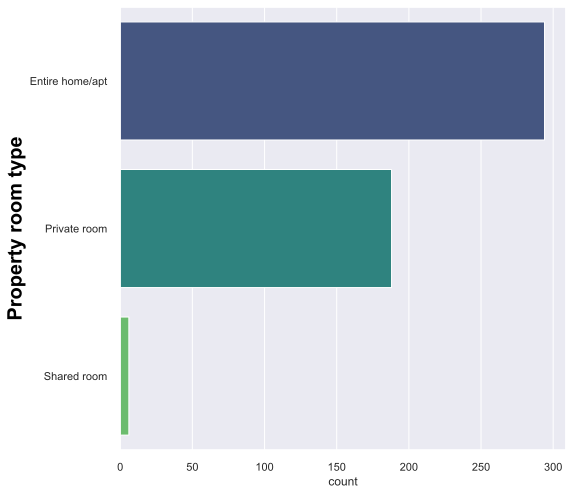

In [34]:
sns.set(style='darkgrid')
plt.figure(figsize=(8,8))
sns.countplot(y = 'property_room_type',data = df,order = df['property_room_type'].value_counts().index,palette = "viridis")
plt.ylabel('Property room type',fontsize = 20, weight = 'bold',color='black')
#plt.axes().set(facecolor = "White")
plt.show()

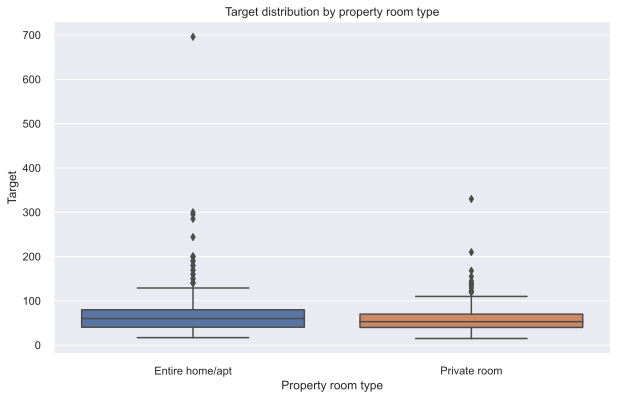

In [36]:
# filter the dataframe to only include rows with property_room_type that appear more than 300 times
room_type_counts = df['property_room_type'].value_counts()
popular_room_types = room_type_counts[room_type_counts > 100].index.tolist()
filtered_df = df[df['property_room_type'].isin(popular_room_types)]

# generate the boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='property_room_type', y='target', data=filtered_df)
ax.set_title('Target distribution by property room type')
ax.set_xlabel('Property room type')
ax.set_ylabel('Target')
plt.show()



In [38]:
# generate the statistical description
filtered_df.groupby('property_room_type')['target'].describe()

,count,mean,std,min,25%,50%,75%,max
property_room_type,,,,,,,,
Entire home/apt,294.0,70.261905,56.927978,17.0,40.5,60.0,80.0,696.0
Private room,188.0,61.648936,37.157335,15.0,40.0,53.0,70.0,330.0


In [39]:
## EDA: property_max_guests

In [44]:
corr_table_maxguests = df[['target', 'property_max_guests']].corr()
print(corr_table_maxguests)

                       target  property_max_guests
target               1.000000             0.064793
property_max_guests  0.064793             1.000000


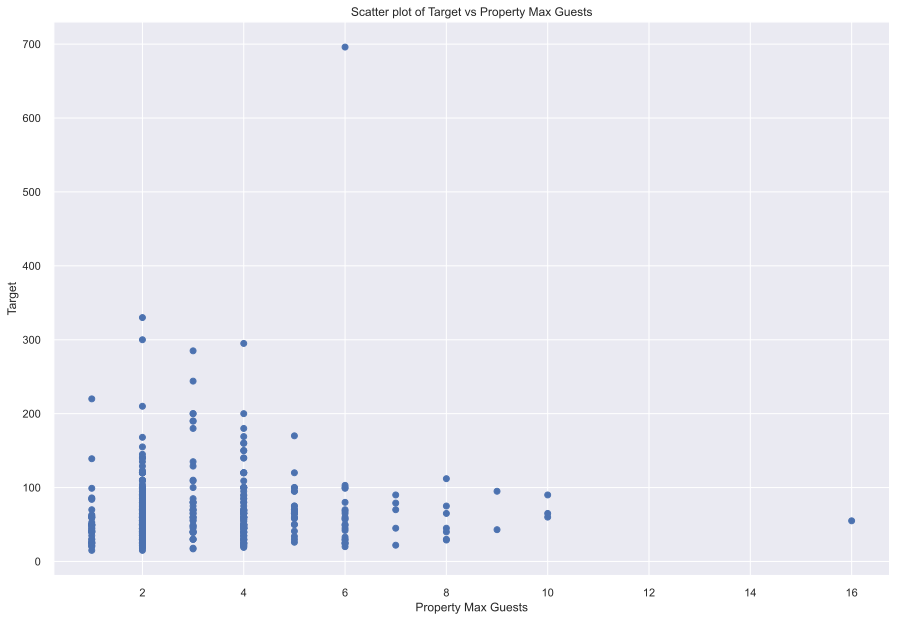

In [42]:
# create a scatter plot of target and property_max_guests
plt.scatter(df['property_max_guests'], df['target'])

# add labels and title
plt.xlabel('Property Max Guests')
plt.ylabel('Target')
plt.title('Scatter plot of Target vs Property Max Guests')

# display the plot
plt.show()


In [47]:
## EDA: property_bathrooms

In [53]:
corr_table_bathrooms = df[['target', 'property_bathrooms']].corr()
print(corr_table_bathrooms)

                      target  property_bathrooms
target              1.000000           -0.004386
property_bathrooms -0.004386            1.000000


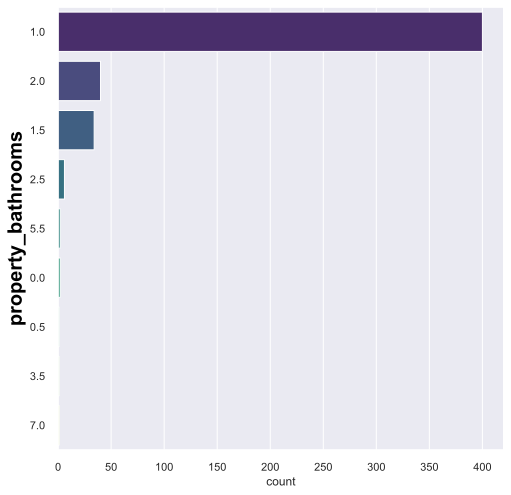

In [49]:
sns.set(style='darkgrid')
plt.figure(figsize=(8,8))
sns.countplot(y = 'property_bathrooms',data = df, order = df['property_bathrooms'].value_counts().index,palette = "viridis")
plt.ylabel('property_bathrooms',fontsize = 20, weight = 'bold',color='black')
#plt.axes().set(facecolor = "White")
plt.show()

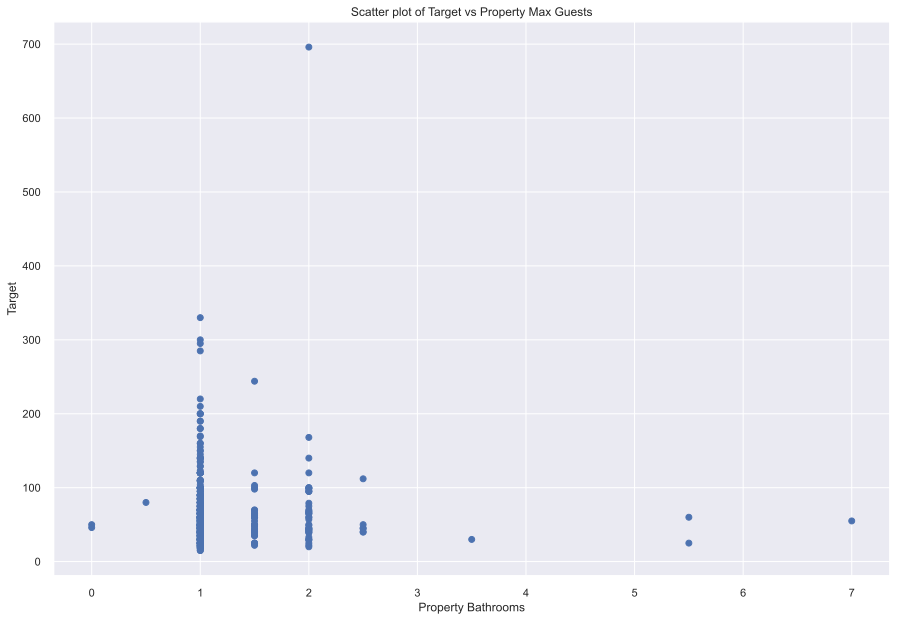

In [50]:
# create a scatter plot of target and property_max_guests
plt.scatter(df['property_bathrooms'], df['target'])

# add labels and title
plt.xlabel('Property Bathrooms')
plt.ylabel('Target')
plt.title('Scatter plot of Target vs Property Max Guests')

# display the plot
plt.show()

In [67]:
## EDA: property_bedrooms

In [68]:
corr_table_bedrooms = df[['target', 'property_bedrooms']].corr()
print(corr_table_bedrooms)

                    target  property_bedrooms
target             1.00000            0.01672
property_bedrooms  0.01672            1.00000


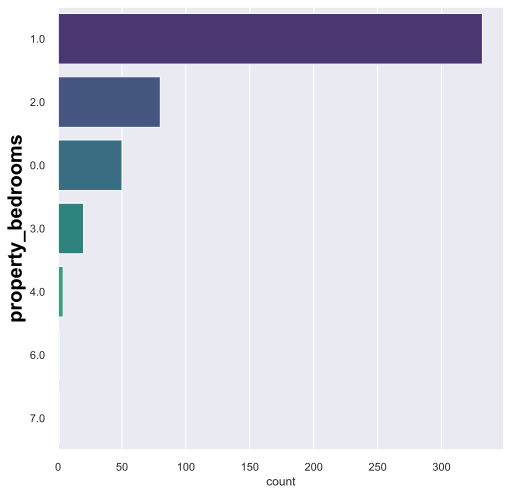

In [70]:
sns.set(style='darkgrid')
plt.figure(figsize=(8,8))
sns.countplot(y = 'property_bedrooms',data = df, order = df['property_bedrooms'].value_counts().index,palette = "viridis")
plt.ylabel('property_bedrooms',fontsize = 20, weight = 'bold',color='black')
#plt.axes().set(facecolor = "White")
plt.show()

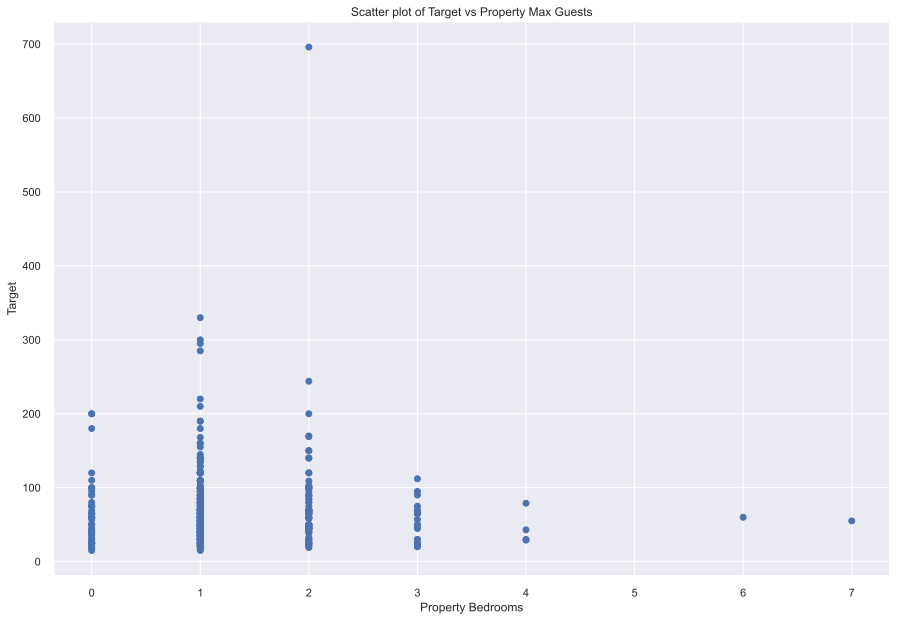

In [71]:
# create a scatter plot of target and property_max_guests
plt.scatter(df['property_bedrooms'], df['target'])

# add labels and title
plt.xlabel('Property Bedrooms')
plt.ylabel('Target')
plt.title('Scatter plot of Target vs Property Max Guests')

# display the plot
plt.show()

Text(149.8888888888889, 0.5, '\\Bedroolms')

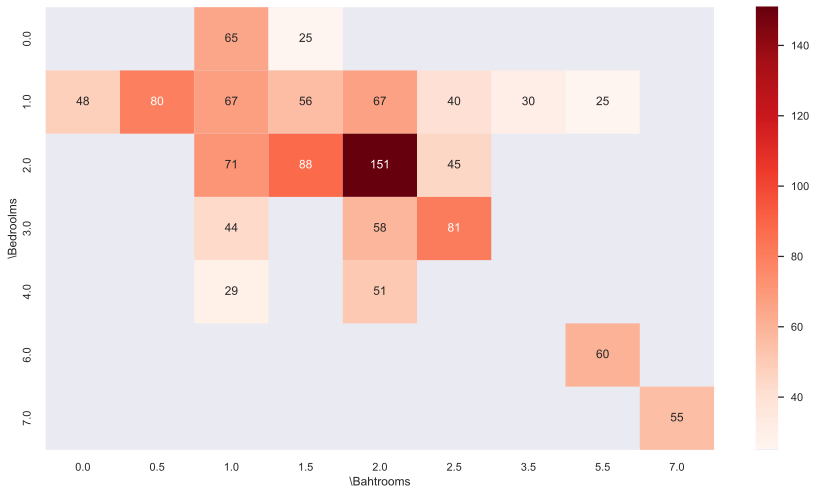

In [72]:
plt.figure(figsize=(15,8))
sns.heatmap(df.groupby(['property_bedrooms', 'property_bathrooms']).target.mean().unstack(), 
            cmap='Reds', annot=True, fmt=".0f")

plt.xlabel('\Bahtrooms', fontsize=12)
plt.ylabel('\Bedroolms', fontsize=12)


In [73]:
## EDA: property_beds

In [75]:
corr_table_beds = df[['target', 'property_beds']].corr()
print(corr_table_beds)

                 target  property_beds
target         1.000000       0.033364
property_beds  0.033364       1.000000


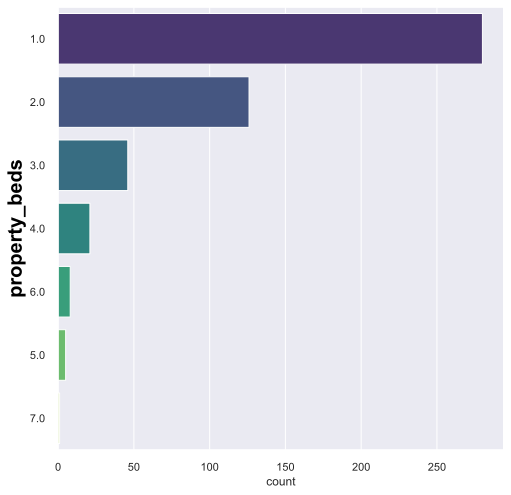

In [76]:
sns.set(style='darkgrid')
plt.figure(figsize=(8,8))
sns.countplot(y = 'property_beds',data = df, order = df['property_beds'].value_counts().index,palette = "viridis")
plt.ylabel('property_beds',fontsize = 20, weight = 'bold',color='black')
#plt.axes().set(facecolor = "White")
plt.show()

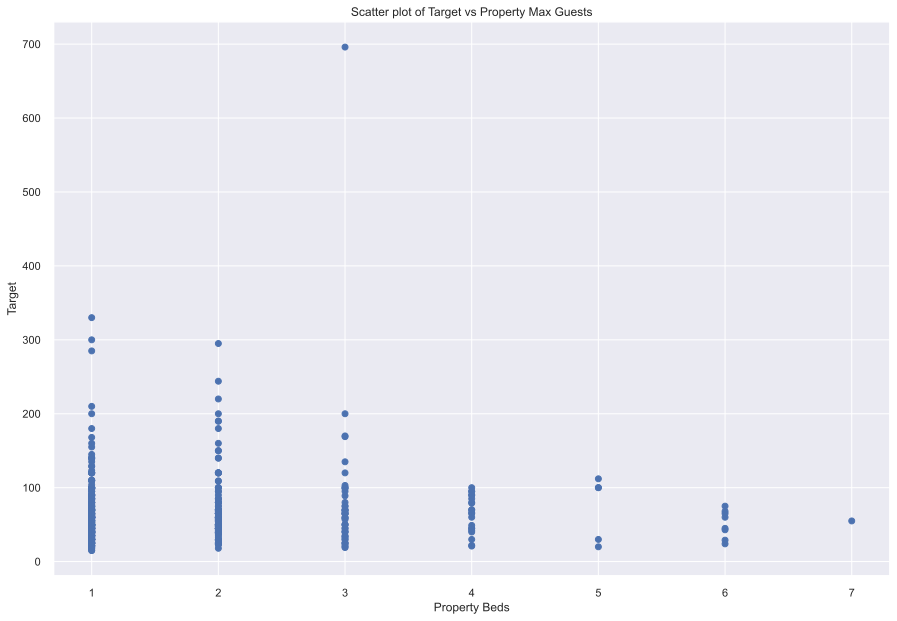

In [77]:
# create a scatter plot of target and property_max_guests
plt.scatter(df['property_beds'], df['target'])

# add labels and title
plt.xlabel('Property Beds')
plt.ylabel('Target')
plt.title('Scatter plot of Target vs Property Max Guests')

# display the plot
plt.show()

In [80]:
## EDA: property_bed_type

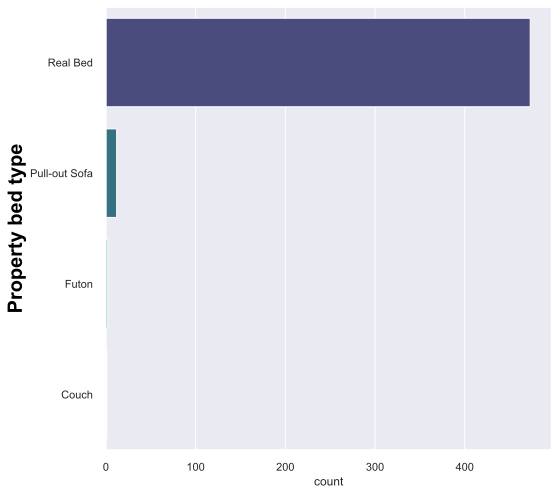

In [81]:
sns.set(style='darkgrid')
plt.figure(figsize=(8,8))
sns.countplot(y = 'property_bed_type',data = df,order = df['property_bed_type'].value_counts().index,palette = "viridis")
plt.ylabel('Property bed type',fontsize = 20, weight = 'bold',color='black')
#plt.axes().set(facecolor = "White")
plt.show()

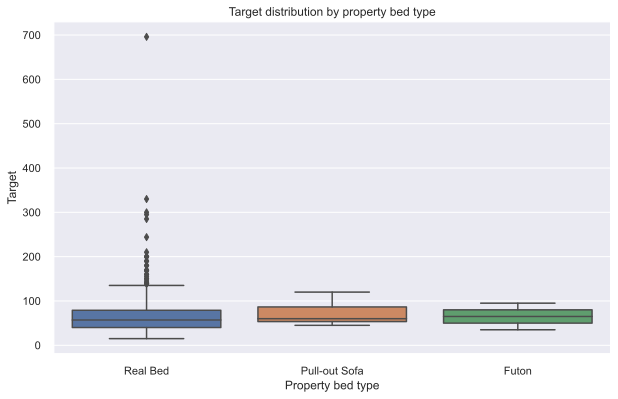

In [86]:
# filter the dataframe to only include rows with property_room_type that appear more than 300 times
bed_type_counts = df['property_bed_type'].value_counts()
popular_bed_types = bed_type_counts[bed_type_counts > 100].index.tolist()
filtered_df_bed = df[df['property_bed_type'].isin(popular_bed_types)]

# generate the boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='property_bed_type', y='target', data=filtered_df)
ax.set_title('Target distribution by property bed type')
ax.set_xlabel('Property bed type')
ax.set_ylabel('Target')
plt.show()

In [85]:
# generate the statistical description
filtered_df_bed.groupby('property_bed_type')['target'].describe()

,count,mean,std,min,25%,50%,75%,max
property_bed_type,,,,,,,,
Couch,1.0,75.000000,NaN,75.0,75.0,75.0,75.00,75.0
Futon,2.0,65.000000,42.426407,35.0,50.0,65.0,80.00,95.0
Pull-out Sofa,12.0,70.500000,27.177865,42.0,50.0,60.0,85.75,120.0
Real Bed,473.0,67.262156,51.197803,15.0,40.0,57.0,80.00,696.0


In [87]:
## EDA: property_amenities

Text(0.5, 1.0, 'Frequency of Amenities in Airbnb Listings')

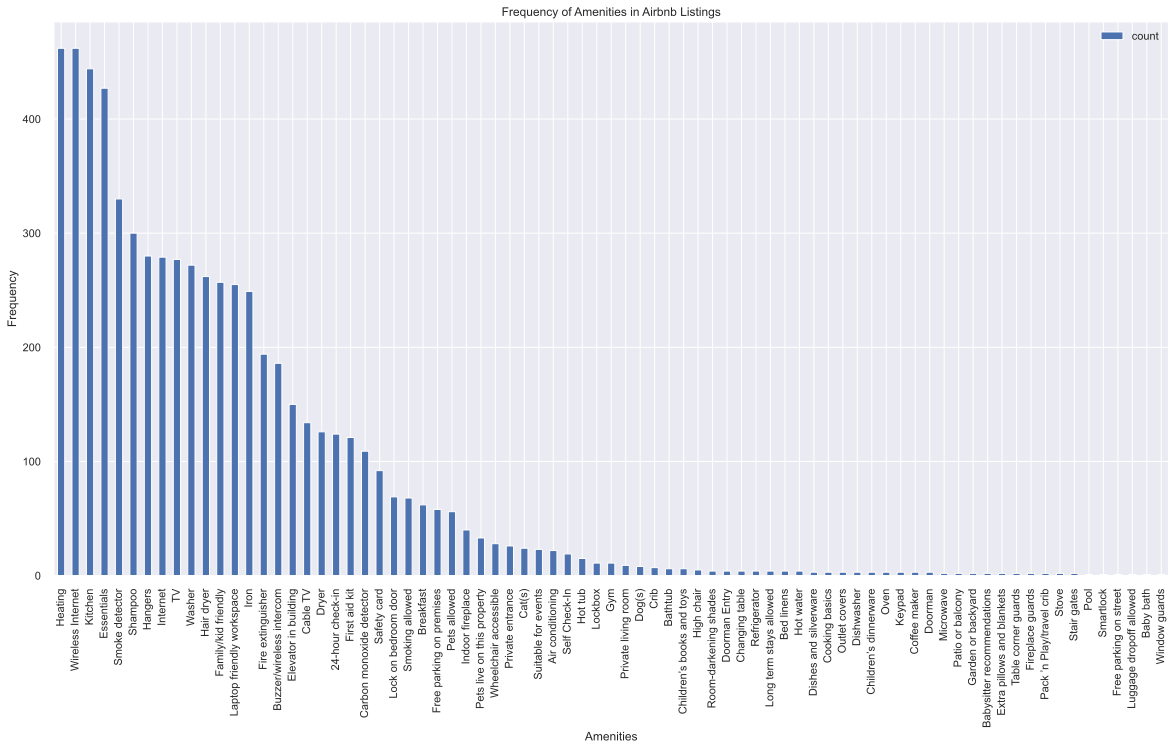

In [88]:
# extract the set of all amenities
amenities_list = df['property_amenities'].tolist()
amenities_set = set()
for amenity_string in amenities_list:
    if pd.notnull(amenity_string):
        amenities = amenity_string.split(',')
        for amenity in amenities:
            stripped_amenity = amenity.strip()
            if stripped_amenity and stripped_amenity not in ['translation missing: en.hosting_amenity_49', 'translation missing: en.hosting_amenity_50']:
                amenities_set.add(stripped_amenity)

# create a histogram of the frequency of amenities
amenities_counts = {}
for amenity in amenities_set:
    amenities_counts[amenity] = 0
for amenity_string in amenities_list:
    if pd.notnull(amenity_string):
        amenities = amenity_string.split(',')
        for amenity in amenities:
            stripped_amenity = amenity.strip()
            if stripped_amenity and stripped_amenity not in ['translation missing: en.hosting_amenity_49', 'translation missing: en.hosting_amenity_50']:
                amenities_counts[stripped_amenity] += 1
amenities_counts_df = pd.DataFrame.from_dict(amenities_counts, orient='index', columns=['count'])
amenities_counts_df = amenities_counts_df.sort_values(by='count', ascending=False)
amenities_counts_df.plot(kind='bar', figsize=(20,10))
plt.xlabel('Amenities')
plt.ylabel('Frequency')
plt.title('Frequency of Amenities in Airbnb Listings')

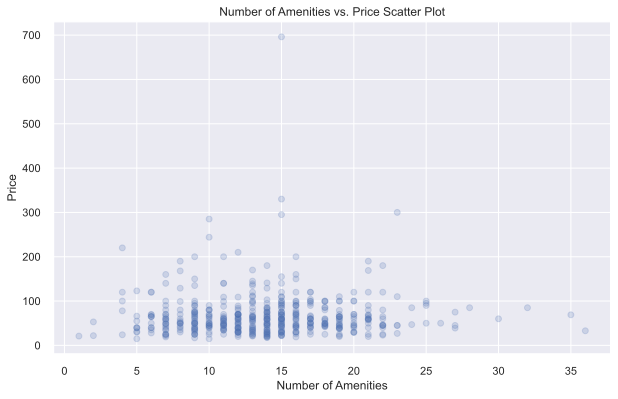

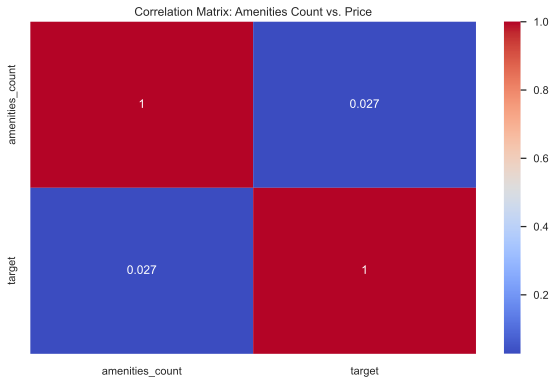

In [89]:
# create a new column with the count of amenities for each listing
df['amenities_count'] = df['property_amenities'].str.split(',').str.len()

# create a scatter plot of amenities_count vs. target
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df['amenities_count'], df['target'], alpha=0.2)
ax.set_xlabel('Number of Amenities')
ax.set_ylabel('Price')
ax.set_title('Number of Amenities vs. Price Scatter Plot')

# create a correlation matrix between amenities_count and target
corr = df[['amenities_count', 'target']].corr()
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)
ax.set_title('Correlation Matrix: Amenities Count vs. Price')
plt.show()


In [90]:
## EDA: host_since

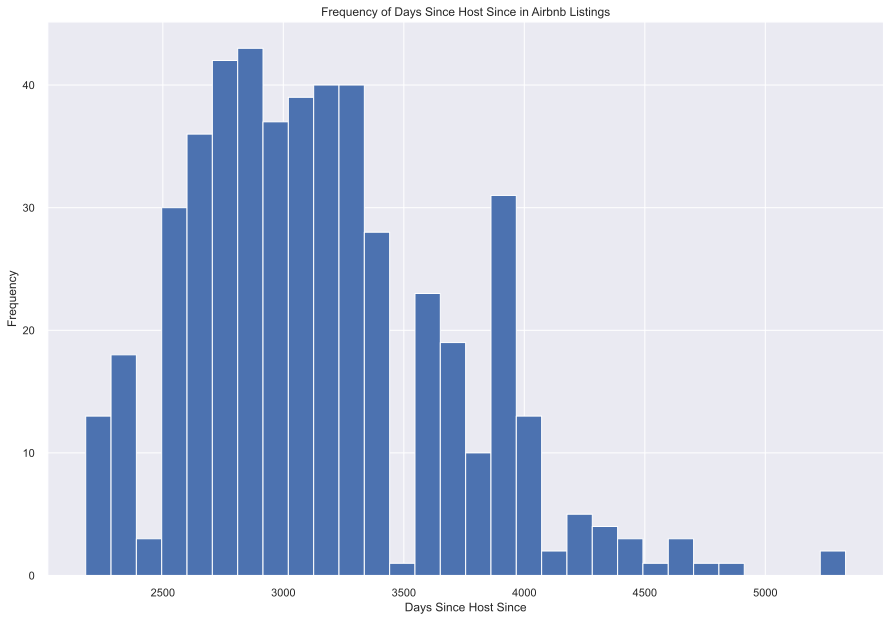

In [91]:
import datetime

# convert host_since to datetime
df['host_since'] = pd.to_datetime(df['host_since'])

# calculate the days since host_since
now = datetime.datetime.now()
df['days_since_host'] = (now - df['host_since']).dt.days

# plot a histogram of the frequency of days since host_since
df['days_since_host'].plot(kind='hist', bins=30)
plt.xlabel('Days Since Host Since')
plt.ylabel('Frequency')
plt.title('Frequency of Days Since Host Since in Airbnb Listings')
plt.show()

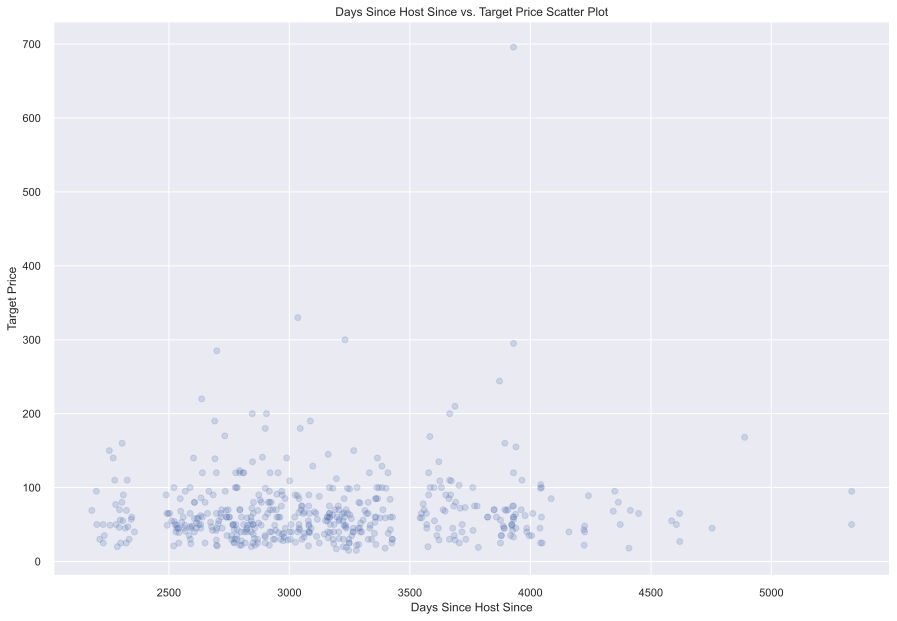

In [92]:
# Convert host_since to datetime format
df['host_since'] = pd.to_datetime(df['host_since'])

# Calculate the number of days since host_since
df['days_since_host_since'] = (pd.Timestamp.today() - df['host_since']).dt.days

# Create a scatter plot of the number of days since host_since vs. target price
plt.scatter(df['days_since_host_since'], df['target'], alpha=0.2)
plt.xlabel('Days Since Host Since')
plt.ylabel('Target Price')
plt.title('Days Since Host Since vs. Target Price Scatter Plot')
plt.show()

<AxesSubplot:>

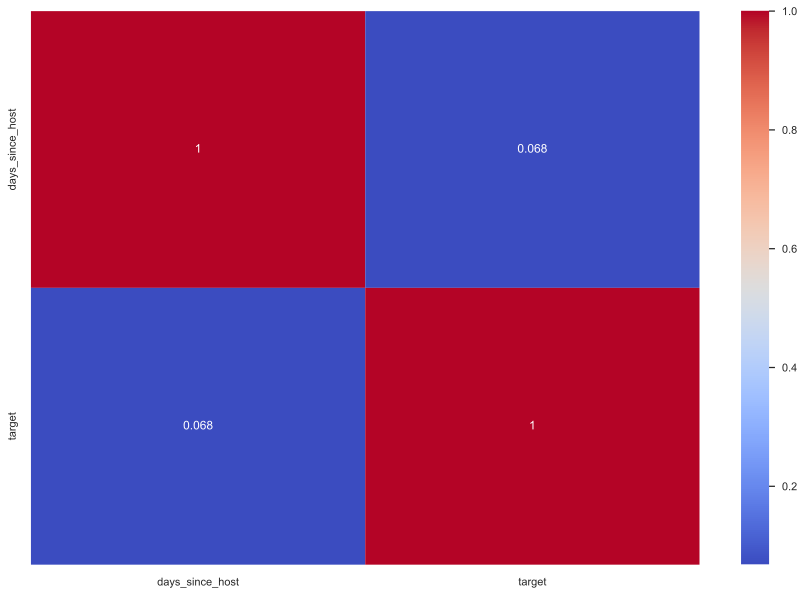

In [93]:
sns.set(style="white")

# create a new column 'days_since_host' with the number of days since the host's first registered listing
df['days_since_host'] = (pd.to_datetime('today') - pd.to_datetime(df['host_since'])).dt.days

# create a scatter plot of days_since_host vs target
sns.scatterplot(x='days_since_host', y='target', data=df)

# create a correlation plot of days_since_host and target
corr = df[['days_since_host', 'target']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

In [94]:
## EDA: host_response_time

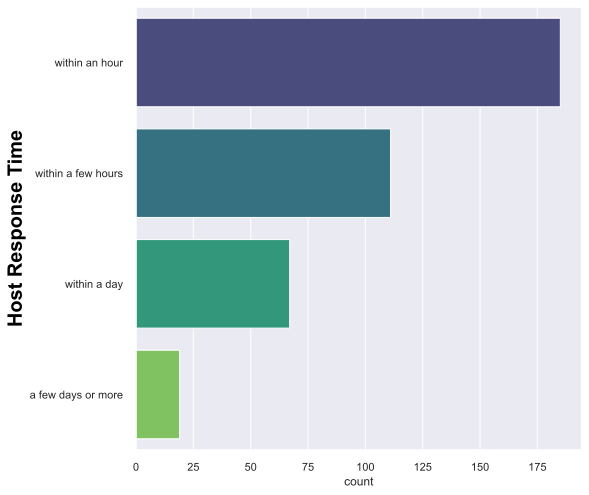

In [95]:
sns.set(style='darkgrid')
plt.figure(figsize=(8,8))
sns.countplot(y = 'host_response_time',data = df,order = df['host_response_time'].value_counts().index,palette = "viridis")
plt.ylabel('Host Response Time',fontsize = 20, weight = 'bold',color='black')
#plt.axes().set(facecolor = "White")
plt.show()

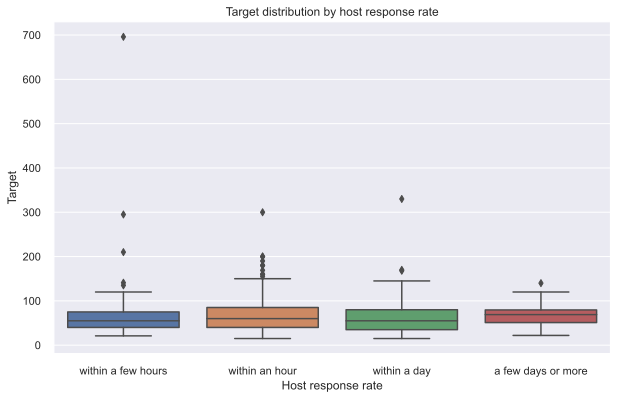

In [100]:
# filter the dataframe to only include rows with property_room_type that appear more than 300 times
host_response_counts = df['host_response_time'].value_counts()
popular_host_response_rate = host_response_counts[host_response_counts > 50].index.tolist()
filtered_df_response = df[df['host_response_time'].isin(popular_host_response_rate)]

# generate the boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='host_response_time', y='target', data=filtered_df)
ax.set_title('Target distribution by host response rate')
ax.set_xlabel('Host response rate')
ax.set_ylabel('Target')
plt.show()

In [99]:
# generate the statistical description
filtered_df_response.groupby('host_response_time')['target'].describe()

,count,mean,std,min,25%,50%,75%,max
host_response_time,,,,,,,,
a few days or more,19.0,72.000000,32.376260,22.0,51.0,69.0,79.5,140.0
within a day,67.0,67.850746,48.902269,15.0,37.5,55.0,83.0,330.0
within a few hours,111.0,67.603604,70.577524,21.0,40.0,55.0,75.0,696.0
within an hour,185.0,67.205405,40.553252,15.0,40.0,60.0,85.0,300.0


In [101]:
## EDA: host_response_rate

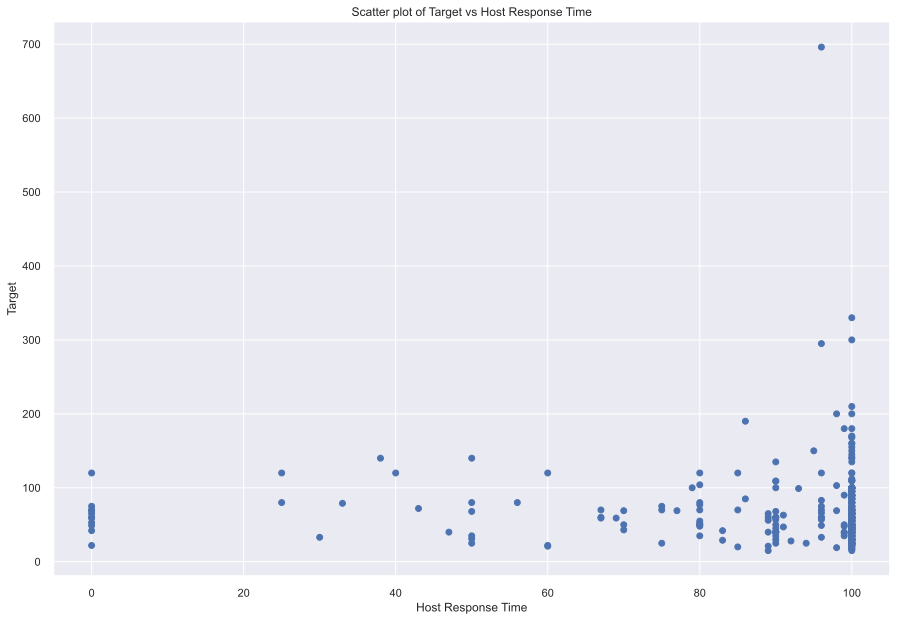

In [102]:
# create a scatter plot of target and property_max_guests
plt.scatter(df['host_response_rate'], df['target'])

# add labels and title
plt.xlabel('Host Response Time')
plt.ylabel('Target')
plt.title('Scatter plot of Target vs Host Response Time')

# display the plot
plt.show()

In [107]:
corr_table_response_time = df[['target', 'host_response_rate']].corr()
print(corr_table_response_time)

                      target  host_response_rate
target              1.000000           -0.001605
host_response_rate -0.001605            1.000000


In [108]:
## EDA: host_nr_listings

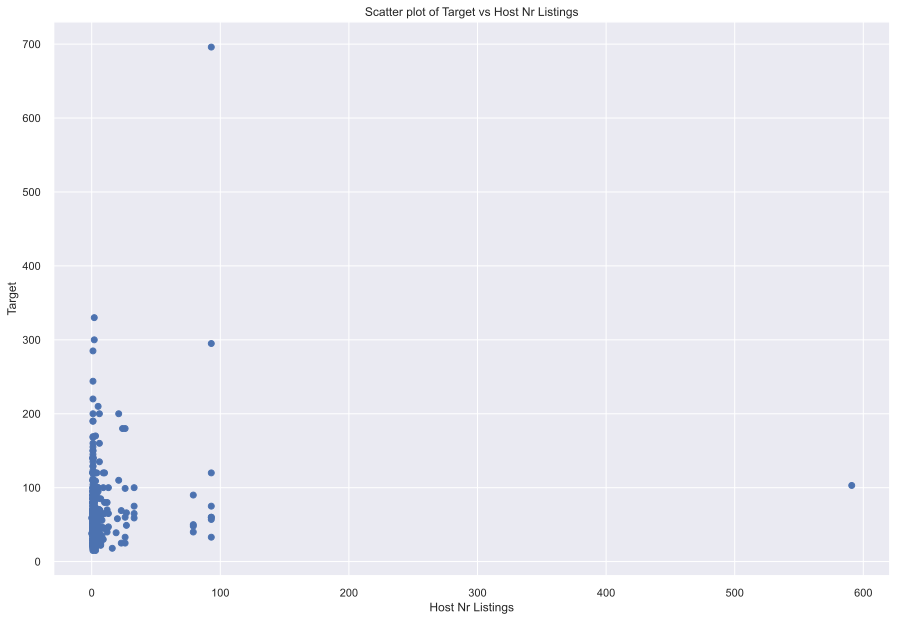

In [109]:
# create a scatter plot of target and property_max_guests
plt.scatter(df['host_nr_listings'], df['target'])

# add labels and title
plt.xlabel('Host Nr Listings')
plt.ylabel('Target')
plt.title('Scatter plot of Target vs Host Nr Listings')

# display the plot
plt.show()

In [112]:
corr_table_listings = df[['target', 'host_nr_listings']].corr()
print(corr_table_listings)

                    target  host_nr_listings
target            1.000000          0.137006
host_nr_listings  0.137006          1.000000
